In [ ]:
import pandas as pd
import numpy as np


# Handling images
from PIL import Image
import matplotlib.pyplot as plt

# Handling paths

import time

# Pytorch essentials
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision.datasets import ImageFolder


# Pytorch essentials for datasets.
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader

# Pytorch way of data augmentation.
from torchvision.transforms import v2

import cv2
import os
from glob import glob
from tqdm import tqdm
import shutil
from sklearn.model_selection import train_test_split


import albumentations as A
from albumentations.pytorch import ToTensorV2
! pip install segmentation-models-pytorch
import segmentation_models_pytorch as smp

# For colab implementation
from google.colab import drive
drive.mount('/content/drive', force_remount = True)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.9 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=ea3218cd6369a0f3445009f6002779034f8579544fb308f8c096cd50349f8d4e
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=cdb977314863f0ceb23782c86ecf1fb56fbd4e725fa813fb631ef6a795969ac5
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels
Mounted at /content/drive


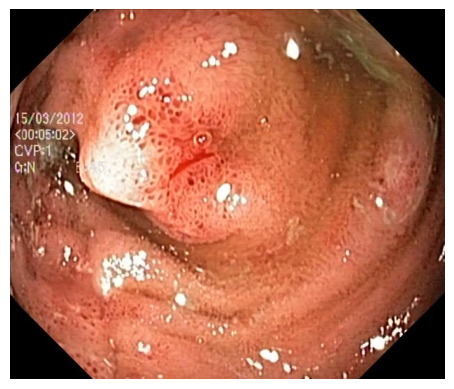

In [ ]:
import cv2
from matplotlib import pyplot as plt

# Open an image file
image_path = "/content/drive/MyDrive/Kvasir-SEG/images/cju0qkwl35piu0993l0dewei2.jpg"
image = cv2.imread(image_path)

# Convert BGR to RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

In [ ]:
data_dir1 = '/content/drive/MyDrive/Kvasir-SEG/images/'
# Get the list of image file names
image_file_name = [file_name for file_name in os.listdir(data_dir1) if file_name.endswith('.jpg')]
data_dir2 = '/content/drive/MyDrive/Kvasir-SEG/masks/'

# Get the list of mask file names
mask_file_name = [file_name for file_name in os.listdir(data_dir2) if file_name.endswith('.jpg')]

# Delete duplicate images
filtered_file_names = [file_name for file_name in image_file_name if "(1)" not in os.path.splitext(file_name)[0]]

# Sort names to have a correct mapping
image_file_names = sorted(filtered_file_names)
mask_file_names = sorted(mask_file_name)




print(len([os.path.join(data_dir2, image) for image in image_file_names]))
print(len([os.path.join(data_dir2, image) for image in mask_file_names]))
# Create a dataframe of addresses
data = {'Image': [os.path.join(data_dir1, image) for image in image_file_names],
        'Mask': [os.path.join(data_dir2, mask) for mask in mask_file_names]}

df = pd.DataFrame(data)
print(df.head)

1000
1000
<bound method NDFrame.head of                                                  Image  \
0    /content/drive/MyDrive/Kvasir-SEG/images/cju0q...   
1    /content/drive/MyDrive/Kvasir-SEG/images/cju0q...   
2    /content/drive/MyDrive/Kvasir-SEG/images/cju0q...   
3    /content/drive/MyDrive/Kvasir-SEG/images/cju0r...   
4    /content/drive/MyDrive/Kvasir-SEG/images/cju0r...   
..                                                 ...   
995  /content/drive/MyDrive/Kvasir-SEG/images/ck2bx...   
996  /content/drive/MyDrive/Kvasir-SEG/images/ck2bx...   
997  /content/drive/MyDrive/Kvasir-SEG/images/ck2bx...   
998  /content/drive/MyDrive/Kvasir-SEG/images/ck2bx...   
999  /content/drive/MyDrive/Kvasir-SEG/images/ck2da...   

                                                  Mask  
0    /content/drive/MyDrive/Kvasir-SEG/masks/cju0qk...  
1    /content/drive/MyDrive/Kvasir-SEG/masks/cju0qo...  
2    /content/drive/MyDrive/Kvasir-SEG/masks/cju0qx...  
3    /content/drive/MyDrive/Kvasir-

In [ ]:
# Create a transformation for dataset, containing a bit of augmentation
train_transforms = A.Compose([
    A.Resize(320, 320),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    ]
)

test_transforms = A.Compose([
    A.Resize(320, 320),
    ],
)

# Create the data set class for dataloader

class MyDataset(torch.utils.data.Dataset):

    def __init__(self, dataframe, transforms_=None):
        self.df = dataframe
        self.transforms_ = transforms_
        self.resize = [320, 320]
        self.class_size = 2

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
      # read each image for getitem and its corresponding mask
        img = np.array(Image.open(self.df.iloc[index][0]).convert('RGB'))
        mask = np.array(Image.open(self.df.iloc[index][1]).convert('L'))
        mask = np.where(mask<127, 0, 1).astype(np.int16)
        aug = self.transforms_(image=img, mask=mask)
        img, mask = aug['image'], aug['mask']
        img = img/255
        # change to tensor and permute it to have the right form.
        img = torch.tensor(img, dtype=torch.float).permute(2, 0, 1)
        target = torch.tensor(mask, dtype=torch.long)
        sample = {'x': img, 'y': target}
        return sample

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available else "cpu")

# Split the data set into thre parts : train, validation, test

train_df, val_test_df = train_test_split(df, test_size=0.2,random_state = 100)
val_df, test_df = train_test_split(val_test_df, test_size=0.5,random_state = 100)

# Change df to dataset
train_dataset = MyDataset(train_df, train_transforms)
val_dataset = MyDataset(val_df, test_transforms)
test_dataset = MyDataset(test_df, test_transforms)

# Create dataloader with 32-sized batches
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
print(f'len train: {len(train_df)}')
print(f'len val: {len(val_df)}')
print(f'len test: {len(test_df)}')

len train: 800
len val: 100
len test: 100


In [ ]:
# Create the model with Unet(resnet50)

class_size = 1
model = smp.Unet(
    encoder_name="resnet50",
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # Cause it's RGB
    classes=class_size,                      # our mask is binary
)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 102MB/s]


In [ ]:
# Train model
def train(dataloader, model, loss_fn, optimizer, lr_scheduler):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch
    model.train() # to training mode.
    epoch_loss = 0
    epoch_iou_score = 0
    for batch_i, batch in enumerate(dataloader):
        x, y = batch['x'].to(device), batch['y'].to(device)
        optimizer.zero_grad()
        pred = model(x)
        loss = loss_fn(pred, y)

        loss.backward() # backpropagate
        optimizer.step() # update model parameters

        epoch_loss += loss.item()
        pred = pred.squeeze(dim=1)
        pred = torch.sigmoid(pred)
        y = y.round().long()
        # Get metrics
        tp, fp, fn, tn = smp.metrics.get_stats(pred, y, mode='binary', threshold=0.5)
        # Calculate IOU using metrics
        iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro").item()
        epoch_iou_score += iou_score
        lr_scheduler.step()
    # return avg loss of epoch, acc of epoch for future plotting
    return epoch_loss/num_batches, epoch_iou_score/num_batches


# Calculate loss for validation to set to see if it converges
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch

    model.eval() # model to test mode.
    epoch_loss = 0
    epoch_iou_score = 0
    with torch.no_grad():
        for batch_i, batch in enumerate(dataloader):
            x, y = batch['x'].to(device), batch['y'].to(device) # move data to GPU

            # Compute prediction loss
            pred = model(x)
            loss = loss_fn(pred, y)

            # update values
            epoch_loss += loss.item()
            pred = pred.squeeze(dim=1)
            pred = torch.sigmoid(pred)
            y = y.round().long()

            # Get metrics
            tp, fp, fn, tn = smp.metrics.get_stats(pred, y, mode='binary', threshold=0.5)

            # Calculate IOU using metrics
            iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro").item()
            epoch_iou_score += iou_score
    return epoch_loss/num_batches, epoch_iou_score/num_batches

In [ ]:
# Choose number of epochs (The more, the better)
EPOCHS = 20

# Initiate logs
logs = {
    'train_loss': [], 'val_loss': [],
    'train_iou_score': [], 'val_iou_score': [],
}

# Create directory
if os.path.exists('checkpoints') == False:
    os.mkdir("checkpoints")
# Choose the loss function (Here f1 (Dice))
loss_fn = smp.losses.DiceLoss(mode="binary")

learning_rate = 0.001

# choosing optimzer and the learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 200, gamma=0.1)

# Earlystopping Parameters
patience = 5 # Number of times allowing loss to increase
counter = 0
best_loss = np.inf

model.to(device)

for epoch in tqdm(range(EPOCHS)):
  # Get train_loss and iou score for each epoch
    train_loss, train_iou_score = train(train_loader, model, loss_fn, optimizer, step_lr_scheduler)
    val_loss, val_iou_score = test(val_loader, model, loss_fn)
    # Update logs
    logs['train_loss'].append(train_loss)
    logs['val_loss'].append(val_loss)
    logs['train_iou_score'].append(train_iou_score)
    logs['val_iou_score'].append(val_iou_score)


    print(f'EPOCH: {str(epoch+1).zfill(3)} \
    train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f} \
    train_iou_score: {train_iou_score:.3f}, val_iou_score: {val_iou_score:.3f} \
    lr: {optimizer.param_groups[0]["lr"]}')

    # Save model after each epoch
    torch.save(model.state_dict(), "/content/drive/MyDrive/checkpoints/last2.pth")
    # Check improvement
    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        # Save the model
        torch.save(model.state_dict(), "/content/drive/MyDrive/checkpoints/best2.pth")
    else:
        counter += 1
    # Check for Early stop
    if counter >= patience:
        print("Earlystop!")
        break

  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH: 001     train_loss: 0.5729, val_loss: 0.4744     train_iou_score: 0.382, val_iou_score: 0.455     lr: 0.001


  5%|▌         | 1/20 [00:43<13:45, 43.43s/it]

EPOCH: 002     train_loss: 0.4190, val_loss: 0.5285     train_iou_score: 0.530, val_iou_score: 0.370     lr: 0.001


 10%|█         | 2/20 [01:22<12:15, 40.84s/it]

EPOCH: 003     train_loss: 0.3299, val_loss: 0.3486     train_iou_score: 0.576, val_iou_score: 0.519     lr: 0.001


 15%|█▌        | 3/20 [02:02<11:27, 40.46s/it]

EPOCH: 004     train_loss: 0.2862, val_loss: 0.3012     train_iou_score: 0.591, val_iou_score: 0.553     lr: 0.001


 20%|██        | 4/20 [02:43<10:50, 40.68s/it]

EPOCH: 005     train_loss: 0.2505, val_loss: 0.4322     train_iou_score: 0.620, val_iou_score: 0.414     lr: 0.001


 25%|██▌       | 5/20 [03:23<10:08, 40.54s/it]

EPOCH: 006     train_loss: 0.2634, val_loss: 0.2919     train_iou_score: 0.596, val_iou_score: 0.563     lr: 0.001


 30%|███       | 6/20 [04:04<09:30, 40.76s/it]

EPOCH: 007     train_loss: 0.2239, val_loss: 0.2917     train_iou_score: 0.645, val_iou_score: 0.560     lr: 0.001


 35%|███▌      | 7/20 [04:46<08:54, 41.14s/it]

EPOCH: 008     train_loss: 0.2126, val_loss: 0.2693     train_iou_score: 0.658, val_iou_score: 0.582     lr: 0.0001


 40%|████      | 8/20 [05:28<08:13, 41.15s/it]

EPOCH: 009     train_loss: 0.1954, val_loss: 0.1987     train_iou_score: 0.681, val_iou_score: 0.674     lr: 0.0001


 45%|████▌     | 9/20 [06:09<07:32, 41.18s/it]

EPOCH: 010     train_loss: 0.1708, val_loss: 0.1902     train_iou_score: 0.717, val_iou_score: 0.687     lr: 0.0001


 50%|█████     | 10/20 [06:49<06:49, 40.99s/it]

EPOCH: 011     train_loss: 0.1621, val_loss: 0.1837     train_iou_score: 0.729, val_iou_score: 0.695     lr: 0.0001


 55%|█████▌    | 11/20 [07:30<06:07, 40.85s/it]

EPOCH: 012     train_loss: 0.1499, val_loss: 0.1759     train_iou_score: 0.747, val_iou_score: 0.706     lr: 0.0001


 60%|██████    | 12/20 [08:11<05:26, 40.87s/it]

EPOCH: 013     train_loss: 0.1468, val_loss: 0.1787     train_iou_score: 0.752, val_iou_score: 0.702     lr: 0.0001


 65%|██████▌   | 13/20 [08:54<04:50, 41.49s/it]

EPOCH: 014     train_loss: 0.1422, val_loss: 0.1724     train_iou_score: 0.758, val_iou_score: 0.712     lr: 0.0001


 70%|███████   | 14/20 [09:39<04:15, 42.57s/it]

EPOCH: 015     train_loss: 0.1441, val_loss: 0.1686     train_iou_score: 0.756, val_iou_score: 0.716     lr: 0.0001


 75%|███████▌  | 15/20 [10:19<03:29, 41.99s/it]

EPOCH: 016     train_loss: 0.1352, val_loss: 0.1641     train_iou_score: 0.769, val_iou_score: 0.723     lr: 1e-05


 80%|████████  | 16/20 [11:03<02:49, 42.42s/it]

EPOCH: 017     train_loss: 0.1312, val_loss: 0.1630     train_iou_score: 0.776, val_iou_score: 0.725     lr: 1e-05


 85%|████████▌ | 17/20 [11:44<02:06, 42.07s/it]

EPOCH: 018     train_loss: 0.1313, val_loss: 0.1614     train_iou_score: 0.775, val_iou_score: 0.727     lr: 1e-05


 90%|█████████ | 18/20 [12:27<01:24, 42.32s/it]

EPOCH: 019     train_loss: 0.1325, val_loss: 0.1619     train_iou_score: 0.773, val_iou_score: 0.726     lr: 1e-05


 95%|█████████▌| 19/20 [13:07<00:41, 41.76s/it]

EPOCH: 020     train_loss: 0.1304, val_loss: 0.1625     train_iou_score: 0.776, val_iou_score: 0.725     lr: 1e-05


100%|██████████| 20/20 [13:49<00:00, 41.47s/it]


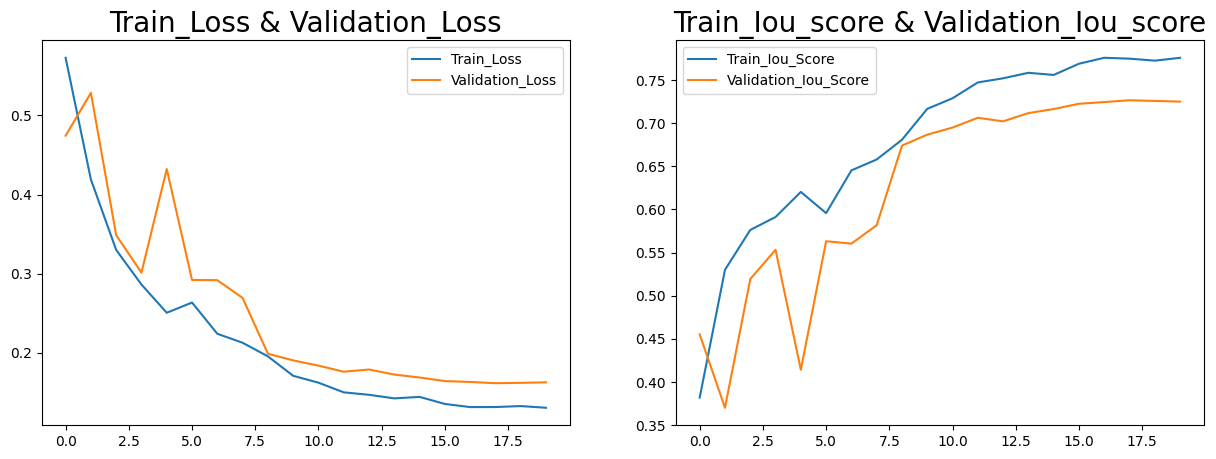

In [ ]:
# plot loss to see if it convreges

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(logs['train_loss'],label='Train_Loss')
plt.plot(logs['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(logs['train_iou_score'],label='Train_Iou_Score')
plt.plot(logs['val_iou_score'],label='Validation_Iou_Score')
plt.title('Train_Iou_score & Validation_Iou_score',fontsize=20)
plt.legend()

In [ ]:
# Introduce dataset class for test
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe,transforms_=None):
        self.df = dataframe
        self.transforms_ = transforms_
        self.resize = [320, 320]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # Read image as rgb
        img = cv2.cvtColor(cv2.imread(self.df.iloc[index][0]), cv2.COLOR_BGR2RGB)
        # Read mask as grayscale
        mask = cv2.imread(self.df.iloc[index][1],cv2.IMREAD_GRAYSCALE)
        # transform data using the transform argument
        aug = self.transforms_(image=img, mask=mask)
        img, mask = aug['image'], aug['mask']
        img_view = np.copy(img)
        img = img/255
        img = torch.tensor(img, dtype=torch.float).permute(2, 0, 1)
        mask_view = np.copy(mask)
        mask = np.where(mask<127, 0, 1).astype(np.int16)
        target = torch.tensor(mask, dtype=torch.long)
        # Save the view for future visualization
        sample = {'x': img, 'y': target, 'img_view':img_view, 'mask_view':mask_view}
        return sample
# Create test data loader
test_dataset = TestDataset(test_df, test_transforms)
test_loader = DataLoader(test_dataset, batch_size=32)

In [ ]:
# Load the model
model.load_state_dict(torch.load('/content/drive/MyDrive/checkpoints/best2.pth'))
model.to(device)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [ ]:
# Get the metrics and evaluate how well the model works
def get_metrics(model, dataloder, threshold):
  # initiate metrics
    IoU_score, precision, f1_score, recall, acc= 0, 0, 0, 0, 0
    batchs = 0
    # Change model to eval mode
    model.eval()
    with torch.no_grad():
        for batch_i, batch in enumerate(dataloder): #for each batch
            x, y = batch['x'].to(device), batch['y'].to(device) # move data to GPU
            # Predict the batch
            pred = model(x)
            pred = pred.squeeze(dim=1)
            pred = torch.sigmoid(pred)
            y = y.round().long()

            # Compute confusion matrix using prediction and y
            tp, fp, fn, tn = smp.metrics.get_stats(pred, y, mode='binary', threshold=threshold)

            # Use confusion matrix to calculate metrics
            batch_iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro").item()
            batch_acc = smp.metrics.accuracy(tp, fp, fn, tn, reduction="micro").item()
            batch_Dice_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro").item()
            batch_recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro").item()
            batch_precision = smp.metrics.precision(tp, fp, fn, tn, reduction="micro").item()

            # Average the metrics towards the batches
            IoU_score += batch_iou_score
            acc += batch_acc
            f1_score += batch_Dice_score
            recall += batch_recall
            precision += batch_precision
            batchs += 1
    IoU_score = round(IoU_score/batchs, 3)
    precision = round(precision/batchs, 3)
    f1_score = round(f1_score/batchs, 3)
    recall = round(recall/batchs, 3)
    acc = round(acc/batchs, 3)
    sample = {'iou':IoU_score, 'pre':precision, 'Dice':f1_score, 're':recall, 'acc':acc}
    return sample


In [ ]:
# Evaluate model's performance with different threshold
threshold_list = [0.3, 0.4, 0.5, 0.6, 0.7]
for threshold in threshold_list:
    sample = get_metrics(model, test_loader, threshold)
    print(f"threshold: {str(threshold)} \
    Dice: {sample['Dice']:.3f} \
    IoU Score: {sample['iou']:.3f} \
    precision: {sample['pre']:.3f} \
    Recall: {sample['re']:.3f} \
    Acc: {sample['acc']:.3f}")

threshold: 0.3     Dice: 0.894     IoU Score: 0.809     precision: 0.904     Recall: 0.887     Acc: 0.971
threshold: 0.4     Dice: 0.894     IoU Score: 0.810     precision: 0.906     Recall: 0.886     Acc: 0.971
threshold: 0.5     Dice: 0.894     IoU Score: 0.810     precision: 0.907     Recall: 0.885     Acc: 0.971
threshold: 0.6     Dice: 0.894     IoU Score: 0.810     precision: 0.909     Recall: 0.883     Acc: 0.971
threshold: 0.7     Dice: 0.894     IoU Score: 0.810     precision: 0.911     Recall: 0.882     Acc: 0.971


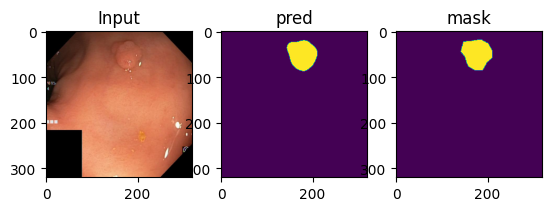

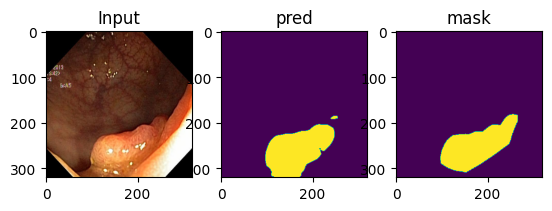

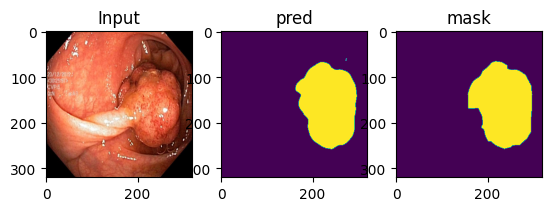

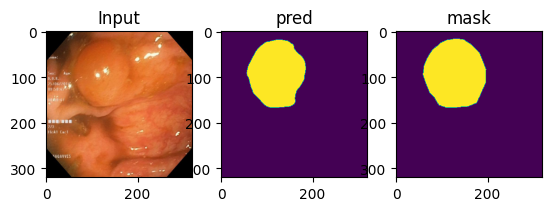

In [ ]:
# Load the model for visualization
model.load_state_dict(torch.load('/content/drive/MyDrive/checkpoints/best2.pth'))
model.to(device)
show_imgs = 4

# Random choice of test set
random_list = np.random.choice(len(test_dataset), show_imgs, replace=False)

# Randomly visualize 4 samples and show the true mask and our prediction
for i in range(show_imgs):
    idx = random_list[i]
    sample = test_dataset[idx]
    pred = model(sample['x'].to('cuda', dtype=torch.float32).unsqueeze(0))
    pred = torch.sigmoid(pred).squeeze(0).squeeze(0)
    pred = pred.data.cpu().numpy()
    pred = np.where(pred<0.5, 0, 1).astype(np.int16)
    pred_img = Image.fromarray(np.uint8(pred), 'L')

    img_view = sample['img_view']
    img_view = Image.fromarray(img_view, 'RGB')

    mask_view = sample['mask_view']
    mask_view = Image.fromarray(mask_view, 'L')

    f, axarr = plt.subplots(1, 3)
    axarr[0].imshow(img_view)
    axarr[0].set_title('Input')
    axarr[1].imshow(pred_img)
    axarr[1].set_title('pred')
    axarr[2].imshow(mask_view)
    axarr[2].set_title('mask')
    plt.show()

In [ ]:
# FPN pretrained model
model2 = smp.FPN(
    encoder_name="resnet18",  # You can choose other encoders like resnet34, resnet50, etc.
    encoder_weights="imagenet",  # Use pre-trained weights on ImageNet
    in_channels=3,  # Number of input channels (e.g., for RGB images)
    classes=1,  # Number of output channels/classes for segmentation
)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 99.2MB/s]


In [ ]:
# Same as previous models
EPOCHS = 20
logs = {
    'train_loss': [], 'val_loss': [],
    'train_iou_score': [], 'val_iou_score': [],
}

if os.path.exists('checkpoints') == False:
    os.mkdir("checkpoints")

loss_fn = smp.losses.DiceLoss(mode="binary")

learning_rate = 0.001
optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate)
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 200, gamma=0.1)


patience = 5
counter = 0
best_loss = np.inf

model2.to(device)
for epoch in tqdm(range(EPOCHS)):
    train_loss, train_iou_score = train(train_loader, model2, loss_fn, optimizer, step_lr_scheduler)
    val_loss, val_iou_score = test(val_loader, model2, loss_fn)
    logs['train_loss'].append(train_loss)
    logs['val_loss'].append(val_loss)
    logs['train_iou_score'].append(train_iou_score)
    logs['val_iou_score'].append(val_iou_score)


    print(f'EPOCH: {str(epoch+1).zfill(3)} \
    train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f} \
    train_iou_score: {train_iou_score:.3f}, val_iou_score: {val_iou_score:.3f} \
    lr: {optimizer.param_groups[0]["lr"]}')


    torch.save(model2.state_dict(), "/content/drive/MyDrive/checkpoints/last_fpn.pth")

    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(model2.state_dict(), "/content/drive/MyDrive/checkpoints/best_fpn.pth")
    else:
        counter += 1
    if counter >= patience:
        print("Earlystop!")
        break

  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH: 001     train_loss: 0.2915, val_loss: 0.3133     train_iou_score: 0.552, val_iou_score: 0.524     lr: 0.001


  5%|▌         | 1/20 [00:22<07:09, 22.59s/it]

EPOCH: 002     train_loss: 0.2312, val_loss: 0.2812     train_iou_score: 0.628, val_iou_score: 0.562     lr: 0.001


 10%|█         | 2/20 [00:45<06:47, 22.62s/it]

EPOCH: 003     train_loss: 0.1988, val_loss: 0.2258     train_iou_score: 0.672, val_iou_score: 0.635     lr: 0.001


 20%|██        | 4/20 [01:30<06:02, 22.65s/it]

EPOCH: 004     train_loss: 0.1837, val_loss: 0.3366     train_iou_score: 0.692, val_iou_score: 0.505     lr: 0.001
EPOCH: 005     train_loss: 0.1816, val_loss: 0.2385     train_iou_score: 0.697, val_iou_score: 0.616     lr: 0.001


 25%|██▌       | 5/20 [01:52<05:37, 22.50s/it]

EPOCH: 006     train_loss: 0.1870, val_loss: 0.1918     train_iou_score: 0.689, val_iou_score: 0.680     lr: 0.001


 30%|███       | 6/20 [02:15<05:13, 22.42s/it]

EPOCH: 007     train_loss: 0.1565, val_loss: 0.1775     train_iou_score: 0.732, val_iou_score: 0.700     lr: 0.001


 35%|███▌      | 7/20 [02:37<04:52, 22.53s/it]

EPOCH: 008     train_loss: 0.1606, val_loss: 0.1563     train_iou_score: 0.727, val_iou_score: 0.732     lr: 0.0001


 40%|████      | 8/20 [03:00<04:30, 22.57s/it]

EPOCH: 009     train_loss: 0.1315, val_loss: 0.1424     train_iou_score: 0.770, val_iou_score: 0.753     lr: 0.0001


 45%|████▌     | 9/20 [03:23<04:09, 22.71s/it]

EPOCH: 010     train_loss: 0.1289, val_loss: 0.1372     train_iou_score: 0.775, val_iou_score: 0.760     lr: 0.0001


 50%|█████     | 10/20 [03:46<03:48, 22.80s/it]

EPOCH: 011     train_loss: 0.1142, val_loss: 0.1376     train_iou_score: 0.798, val_iou_score: 0.760     lr: 0.0001


 60%|██████    | 12/20 [04:30<02:59, 22.39s/it]

EPOCH: 012     train_loss: 0.1127, val_loss: 0.1419     train_iou_score: 0.800, val_iou_score: 0.753     lr: 0.0001


 65%|██████▌   | 13/20 [04:52<02:36, 22.32s/it]

EPOCH: 013     train_loss: 0.1077, val_loss: 0.1433     train_iou_score: 0.808, val_iou_score: 0.751     lr: 0.0001
EPOCH: 014     train_loss: 0.1084, val_loss: 0.1396     train_iou_score: 0.807, val_iou_score: 0.756     lr: 0.0001


 70%|███████   | 14/20 [05:14<02:13, 22.26s/it]

EPOCH: 015     train_loss: 0.1026, val_loss: 0.1368     train_iou_score: 0.816, val_iou_score: 0.761     lr: 0.0001


 75%|███████▌  | 15/20 [05:37<01:51, 22.21s/it]

EPOCH: 016     train_loss: 0.1023, val_loss: 0.1296     train_iou_score: 0.817, val_iou_score: 0.773     lr: 1e-05


 80%|████████  | 16/20 [05:59<01:29, 22.25s/it]

EPOCH: 017     train_loss: 0.0976, val_loss: 0.1317     train_iou_score: 0.825, val_iou_score: 0.768     lr: 1e-05


 90%|█████████ | 18/20 [06:43<00:44, 22.18s/it]

EPOCH: 018     train_loss: 0.1001, val_loss: 0.1322     train_iou_score: 0.821, val_iou_score: 0.768     lr: 1e-05


 95%|█████████▌| 19/20 [07:05<00:22, 22.11s/it]

EPOCH: 019     train_loss: 0.0984, val_loss: 0.1318     train_iou_score: 0.823, val_iou_score: 0.769     lr: 1e-05
EPOCH: 020     train_loss: 0.0958, val_loss: 0.1318     train_iou_score: 0.828, val_iou_score: 0.769     lr: 1e-05


100%|██████████| 20/20 [07:27<00:00, 22.37s/it]


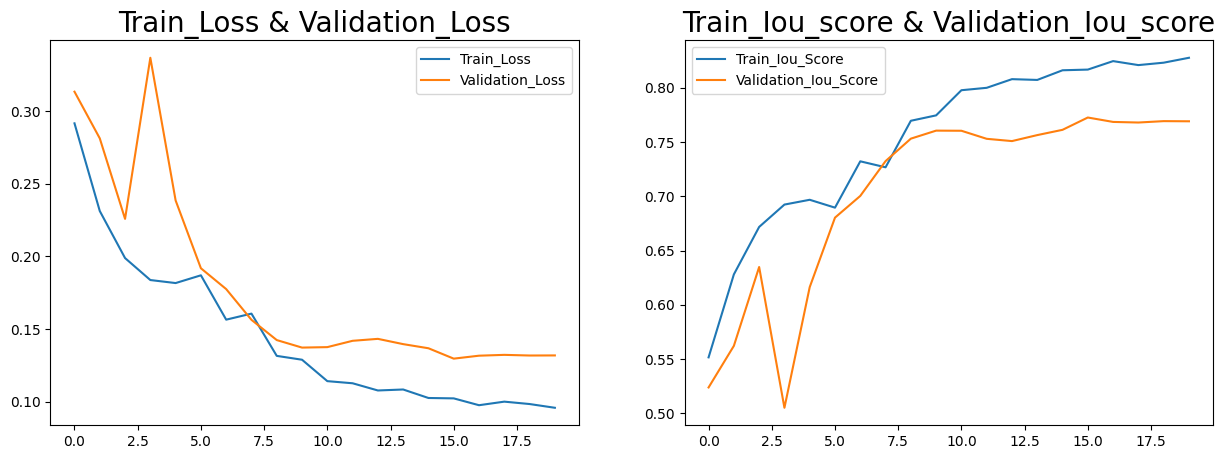

In [ ]:
# Check convergance visually
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(logs['train_loss'],label='Train_Loss')
plt.plot(logs['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(logs['train_iou_score'],label='Train_Iou_Score')
plt.plot(logs['val_iou_score'],label='Validation_Iou_Score')
plt.title('Train_Iou_score & Validation_Iou_score',fontsize=20)
plt.legend()

In [ ]:
# Load model
model2.load_state_dict(torch.load('/content/drive/MyDrive/checkpoints/best_fpn.pth'))
model2.to(device)

FPN(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_

In [ ]:
# Evaluate fpn model's performance with different thresholds
threshold_list = [0.3, 0.4, 0.5, 0.6, 0.7]
for threshold in threshold_list:
    sample = get_metrics(model2, test_loader, threshold)
    print(f"threshold: {str(threshold)} \
    Dice: {sample['Dice']:.3f} \
    IoU Score: {sample['iou']:.3f} \
    precision: {sample['pre']:.3f} \
    Recall: {sample['re']:.3f} \
    Acc: {sample['acc']:.3f}")

threshold: 0.3     Dice: 0.901     IoU Score: 0.821     precision: 0.917     Recall: 0.889     Acc: 0.973
threshold: 0.4     Dice: 0.901     IoU Score: 0.821     precision: 0.920     Recall: 0.886     Acc: 0.973
threshold: 0.5     Dice: 0.901     IoU Score: 0.821     precision: 0.923     Recall: 0.883     Acc: 0.973
threshold: 0.6     Dice: 0.901     IoU Score: 0.820     precision: 0.925     Recall: 0.881     Acc: 0.973
threshold: 0.7     Dice: 0.900     IoU Score: 0.820     precision: 0.928     Recall: 0.878     Acc: 0.973


In [ ]:
# Define a new pretrained Unet model but with resnet101 as encoder
model3 = smp.Unet(
    encoder_name="resnet101",  # You can choose other encoders like resnet34, resnet50, etc.
    encoder_weights="imagenet",  # Use pre-trained weights on ImageNet
    in_channels=3,  # Number of input channels (e.g., for RGB images)
    classes=1,  # Number of output channels/classes for segmentation
)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth
100%|██████████| 170M/170M [00:00<00:00, 268MB/s]


In [ ]:
# Same as previous models
EPOCHS = 20
logs = {
    'train_loss': [], 'val_loss': [],
    'train_iou_score': [], 'val_iou_score': [],
}

if os.path.exists('checkpoints') == False:
    os.mkdir("checkpoints")

loss_fn = smp.losses.DiceLoss(mode="binary")

learning_rate = 0.001
optimizer = torch.optim.Adam(model3.parameters(), lr=learning_rate)
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 200, gamma=0.1)


patience = 5
counter = 0
best_loss = np.inf

model3.to(device)
for epoch in tqdm(range(EPOCHS)):
    train_loss, train_iou_score = train(train_loader, model3, loss_fn, optimizer, step_lr_scheduler)
    val_loss, val_iou_score = test(val_loader, model3, loss_fn)
    logs['train_loss'].append(train_loss)
    logs['val_loss'].append(val_loss)
    logs['train_iou_score'].append(train_iou_score)
    logs['val_iou_score'].append(val_iou_score)


    print(f'EPOCH: {str(epoch+1).zfill(3)} \
    train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f} \
    train_iou_score: {train_iou_score:.3f}, val_iou_score: {val_iou_score:.3f} \
    lr: {optimizer.param_groups[0]["lr"]}')


    torch.save(model3.state_dict(), "/content/drive/MyDrive/checkpoints/last_resnet101.pth")

    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(model3.state_dict(), "/content/drive/MyDrive/checkpoints/best_resnet101.pth")
    else:
        counter += 1
    if counter >= patience:
        print("Earlystop!")
        break

  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH: 001     train_loss: 0.5319, val_loss: 0.4905     train_iou_score: 0.402, val_iou_score: 0.389     lr: 0.001


  5%|▌         | 1/20 [00:53<16:49, 53.15s/it]

EPOCH: 002     train_loss: 0.3811, val_loss: 0.4272     train_iou_score: 0.536, val_iou_score: 0.424     lr: 0.001


 10%|█         | 2/20 [01:45<15:43, 52.42s/it]

EPOCH: 003     train_loss: 0.2968, val_loss: 0.2661     train_iou_score: 0.582, val_iou_score: 0.602     lr: 0.001


 15%|█▌        | 3/20 [02:37<14:54, 52.63s/it]

EPOCH: 004     train_loss: 0.2935, val_loss: 0.3370     train_iou_score: 0.564, val_iou_score: 0.508     lr: 0.001


 20%|██        | 4/20 [03:28<13:48, 51.76s/it]

EPOCH: 005     train_loss: 0.2646, val_loss: 0.4073     train_iou_score: 0.594, val_iou_score: 0.431     lr: 0.001


 25%|██▌       | 5/20 [04:22<13:11, 52.74s/it]

EPOCH: 006     train_loss: 0.2229, val_loss: 0.2125     train_iou_score: 0.645, val_iou_score: 0.655     lr: 0.001


 30%|███       | 6/20 [05:13<12:07, 51.97s/it]

EPOCH: 007     train_loss: 0.2302, val_loss: 0.2605     train_iou_score: 0.634, val_iou_score: 0.592     lr: 0.001


 35%|███▌      | 7/20 [06:02<11:05, 51.20s/it]

EPOCH: 008     train_loss: 0.2071, val_loss: 0.2748     train_iou_score: 0.663, val_iou_score: 0.576     lr: 0.0001


 40%|████      | 8/20 [06:54<10:13, 51.16s/it]

EPOCH: 009     train_loss: 0.1982, val_loss: 0.1989     train_iou_score: 0.676, val_iou_score: 0.672     lr: 0.0001


 45%|████▌     | 9/20 [07:46<09:25, 51.45s/it]

EPOCH: 010     train_loss: 0.1688, val_loss: 0.1895     train_iou_score: 0.718, val_iou_score: 0.685     lr: 0.0001


 50%|█████     | 10/20 [08:39<08:40, 52.02s/it]

EPOCH: 011     train_loss: 0.1530, val_loss: 0.1699     train_iou_score: 0.741, val_iou_score: 0.713     lr: 0.0001


 55%|█████▌    | 11/20 [09:36<08:00, 53.44s/it]

EPOCH: 012     train_loss: 0.1409, val_loss: 0.1692     train_iou_score: 0.759, val_iou_score: 0.715     lr: 0.0001


 60%|██████    | 12/20 [10:29<07:07, 53.41s/it]

EPOCH: 013     train_loss: 0.1351, val_loss: 0.1610     train_iou_score: 0.768, val_iou_score: 0.727     lr: 0.0001


 65%|██████▌   | 13/20 [11:22<06:13, 53.41s/it]

EPOCH: 014     train_loss: 0.1304, val_loss: 0.1583     train_iou_score: 0.776, val_iou_score: 0.731     lr: 0.0001


 70%|███████   | 14/20 [12:14<05:16, 52.81s/it]

EPOCH: 015     train_loss: 0.1323, val_loss: 0.1607     train_iou_score: 0.772, val_iou_score: 0.728     lr: 0.0001


 75%|███████▌  | 15/20 [13:04<04:19, 51.98s/it]

EPOCH: 016     train_loss: 0.1271, val_loss: 0.1681     train_iou_score: 0.781, val_iou_score: 0.717     lr: 1e-05


 80%|████████  | 16/20 [13:56<03:28, 52.16s/it]

EPOCH: 017     train_loss: 0.1259, val_loss: 0.1618     train_iou_score: 0.782, val_iou_score: 0.725     lr: 1e-05


 85%|████████▌ | 17/20 [14:46<02:34, 51.47s/it]

EPOCH: 018     train_loss: 0.1201, val_loss: 0.1608     train_iou_score: 0.792, val_iou_score: 0.727     lr: 1e-05


 90%|█████████ | 18/20 [15:36<01:41, 50.84s/it]

EPOCH: 019     train_loss: 0.1225, val_loss: 0.1592     train_iou_score: 0.787, val_iou_score: 0.729     lr: 1e-05


 90%|█████████ | 18/20 [16:25<01:49, 54.77s/it]

Earlystop!


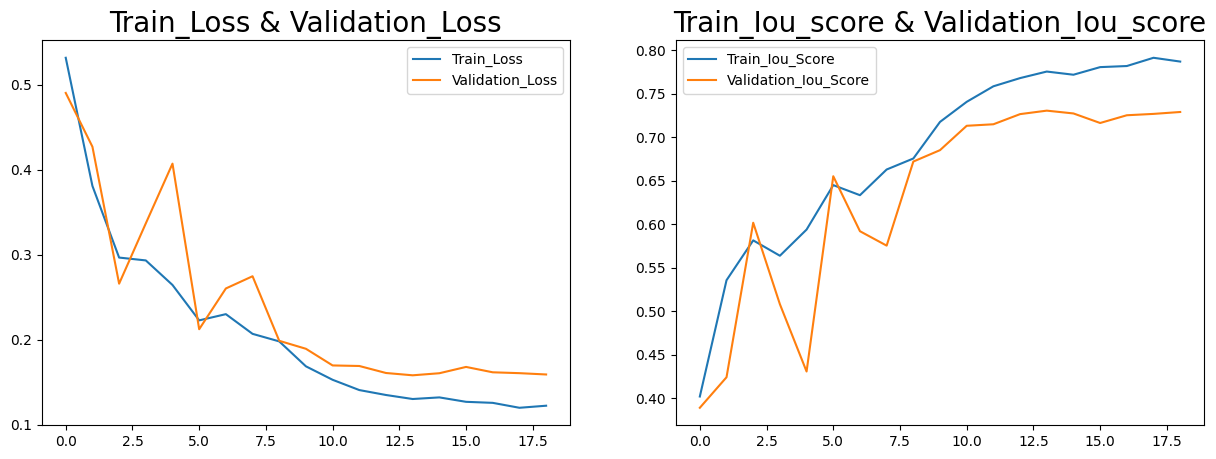

In [ ]:
# Check for convergance visually
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(logs['train_loss'],label='Train_Loss')
plt.plot(logs['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(logs['train_iou_score'],label='Train_Iou_Score')
plt.plot(logs['val_iou_score'],label='Validation_Iou_Score')
plt.title('Train_Iou_score & Validation_Iou_score',fontsize=20)
plt.legend()

In [ ]:
# Load model
model3.load_state_dict(torch.load('/content/drive/MyDrive/checkpoints/best_resnet101.pth'))
model3.to(device)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [ ]:
# Evaluate model's performance with different thresholds
threshold_list = [0.3, 0.4, 0.5, 0.6, 0.7]
for threshold in threshold_list:
    sample = get_metrics(model2, test_loader, threshold)
    print(f"threshold: {str(threshold)} \
    Dice: {sample['Dice']:.3f} \
    IoU Score: {sample['iou']:.3f} \
    precision: {sample['pre']:.3f} \
    Recall: {sample['re']:.3f} \
    Acc: {sample['acc']:.3f}")

threshold: 0.3     Dice: 0.898     IoU Score: 0.817     precision: 0.909     Recall: 0.891     Acc: 0.972
threshold: 0.4     Dice: 0.899     IoU Score: 0.817     precision: 0.912     Recall: 0.889     Acc: 0.972
threshold: 0.5     Dice: 0.899     IoU Score: 0.818     precision: 0.915     Recall: 0.887     Acc: 0.972
threshold: 0.6     Dice: 0.899     IoU Score: 0.818     precision: 0.917     Recall: 0.885     Acc: 0.972
threshold: 0.7     Dice: 0.899     IoU Score: 0.818     precision: 0.920     Recall: 0.883     Acc: 0.972


In [ ]:
# Average all models prediction for test set and take that as the output

# Check for different thresholds
for t in [0.3, 0.4, 0.5, 0.6, 0.7]:
  # initialize metrics
  IoU_score, precision, f1_score, recall, acc= 0, 0, 0, 0, 0

  # Put models in eval mode
  batchs = 0
  model.eval()
  model2.eval()
  model3.eval()
  with torch.no_grad():
    # For each batch
    for batch_i, batch in enumerate(test_loader):
        x, y = batch['x'].to(device), batch['y'].to(device)

        # predict each models output
        pred = model(x)
        pred = pred.squeeze(dim=1)
        output1 = torch.sigmoid(pred)

        pred = model2(x)
        pred = pred.squeeze(dim=1)
        output2 = torch.sigmoid(pred)

        pred = model3(x)
        pred = pred.squeeze(dim=1)
        output3 = torch.sigmoid(pred)

        # average their predictions
        sum_predictions = output1 + output2 + output3
        final_output = (sum_predictions /3)

        # As before now calculate different metrics for this newly predicted value and average it for batches

        tp, fp, fn, tn = smp.metrics.get_stats(final_output, y, mode='binary', threshold = t)
        batch_iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro").item()
        batch_acc = smp.metrics.accuracy(tp, fp, fn, tn, reduction="micro").item()
        batch_Dice_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro").item()
        batch_recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro").item()
        batch_precision = smp.metrics.precision(tp, fp, fn, tn, reduction="micro").item()
        IoU_score += batch_iou_score
        acc += batch_acc
        f1_score += batch_Dice_score
        recall += batch_recall
        precision += batch_precision
        batchs += 1

  IoU_score = round(IoU_score/batchs, 3)
  precision = round(precision/batchs, 3)
  f1_score = round(f1_score/batchs, 3)
  recall = round(recall/batchs, 3)
  acc = round(acc/batchs, 3)

  print(f"Dice: {f1_score:.3f} \
  IoU Score: {IoU_score:.3f} \
  precision: {precision:.3f} \
  Recall: {recall:.3f} \
  Acc: {acc:.3f}")

Dice: 0.893   IoU Score: 0.807   precision: 0.870   Recall: 0.922   Acc: 0.970
Dice: 0.897   IoU Score: 0.815   precision: 0.908   Recall: 0.890   Acc: 0.972
Dice: 0.898   IoU Score: 0.815   precision: 0.913   Recall: 0.886   Acc: 0.972
Dice: 0.898   IoU Score: 0.815   precision: 0.917   Recall: 0.882   Acc: 0.972
Dice: 0.893   IoU Score: 0.809   precision: 0.946   Recall: 0.849   Acc: 0.972


Thanks
